In [1]:
import numpy as np
import os
import pandas as pd
import torch
import torch.optim as optim
import torch.nn as nn
import torch.utils.model_zoo as model_zoo
import torchvision.transforms as transforms
import torchvision.models as models
import time
from PIL import Image, ImageFilter, ImageEnhance
from torch.utils.data import DataLoader
from torch.utils import data
from torch.autograd import Variable
from matplotlib import pyplot as plt
from skimage import io
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

In [2]:
def conv3x3(in_planes, out_planes, stride=1, groups=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, groups=groups, bias=False)

def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)

# Define Network stucture of ResNet

In [3]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1, norm_layer=None):
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1:
            raise ValueError('BasicBlock only supports groups=1')
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1, norm_layer=None):
        super(Bottleneck, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, planes)
        self.bn1 = norm_layer(planes)
        self.conv2 = conv3x3(planes, planes, stride, groups)
        self.bn2 = norm_layer(planes)
        self.conv3 = conv1x1(planes, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=5, zero_init_residual=False,
                 groups=1, width_per_group=64, norm_layer=None):
        super(ResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        planes = [int(width_per_group * groups * 2 ** i) for i in range(4)]
        self.inplanes = planes[0]
        self.conv1 = nn.Conv2d(3, planes[0], kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = norm_layer(planes[0])
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, planes[0], layers[0], groups=groups, norm_layer=norm_layer)
        self.layer2 = self._make_layer(block, planes[1], layers[1], stride=2, groups=groups, norm_layer=norm_layer)
        self.layer3 = self._make_layer(block, planes[2], layers[2], stride=2, groups=groups, norm_layer=norm_layer)
        self.layer4 = self._make_layer(block, planes[3], layers[3], stride=2, groups=groups, norm_layer=norm_layer)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(planes[3] * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1, groups=1, norm_layer=None):
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, groups, norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=groups, norm_layer=norm_layer))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

In [4]:
def resnet18():
    model = ResNet(BasicBlock, [2, 2, 2, 2])
    return model

def resnet50():
    model = ResNet(Bottleneck, [3, 4, 6, 3])       
    return model

# Define Dataloader

In [5]:
def getData(mode):
    if mode == 'train':
        img = pd.read_csv('train_img.csv')
        label = pd.read_csv('train_label.csv')
        return np.squeeze(img.values), np.squeeze(label.values)
    else:
        img = pd.read_csv('test_img.csv')
        label = pd.read_csv('test_label.csv')
        return np.squeeze(img.values), np.squeeze(label.values)


class RetinopathyLoader(data.Dataset):
    def __init__(self, root, mode):
        """
        Args:
            root (string): Root path of the dataset.
            mode : Indicate procedure status(training or testing)

            self.img_name (string list): String list that store all image names.
            self.label (int or float list): Numerical list that store all ground truth label values.
        """
        self.root = root
        self.img_name, self.label = getData(mode)
        self.mode = mode
        self.output_size = (512, 512)
        self.angle_range = (0, 360)
        print("> Found %d images..." % (len(self.img_name)))

    def __len__(self):
        """'return the size of dataset"""
        return len(self.img_name)

    def __getitem__(self, index):
        """something you should implement here"""

        """
           step1. Get the image path from 'self.img_name' and load it.
                  hint : path = root + self.img_name[index] + '.jpeg'
           
           step2. Get the ground truth label from self.label
                     
           step3. Transform the .jpeg rgb images during the training phase, such as resizing, random flipping, 
                  rotation, cropping, normalization etc. But at the beginning, I suggest you follow the hints. 
                       
                  In the testing phase, if you have a normalization process during the training phase, you only need 
                  to normalize the data. 
                  
                  hints : Convert the pixel value to [0, 1]
                          Transpose the image shape from [H, W, C] to [C, H, W]
                         
            step4. Return processed image and label
        """
        
        #Data augmentation
        transform = transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomVerticalFlip(p=0.5),
            transforms.RandomRotation(self.angle_range)
        ])
        
        totensor = transforms.Compose([
            transforms.ToTensor()
        ])
        
        #read image
        img_path = os.path.join(self.root, self.img_name[index]+".jpeg")
        img = io.imread(img_path)
        
        #normalization
        #norm = np.linalg.norm(img)
        #img = img/norm if norm!=0 else img
        
        img = Image.fromarray(img)
        
        if self.mode == 'train':
            img = transform(img)
            if np.random.randint(10) < 2:#random filter
                img = img.filter(ImageFilter.GaussianBlur(3))
            if np.random.randint(10) < 2:#random contrast adjustment
                adjust = np.random.randint(9)+1
                img = ImageEnhance.Contrast(img).enhance(adjust/10)
            
        img = totensor(img)
        
        label = self.label[index]
        label = torch.tensor(label, dtype=torch.long)
        
        return img, label

# Setup Network and Define Config Path

In [6]:
res18_pretrain = models.resnet18(pretrained=True)
res18_pretrain.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
res18_pretrain.fc = nn.Linear(in_features=512, out_features=5, bias=True)
res18_no_pretrain = resnet18()
res50_pretrain = models.resnet50(pretrained=True)
res50_pretrain.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
res50_pretrain.fc = nn.Linear(in_features=2048, out_features=5, bias=True)
res50_no_pretrain = resnet50()

use_gpu = torch.cuda.is_available()
if use_gpu:
    res18_pretrain = res18_pretrain.cuda()
    res18_no_pretrain = res18_no_pretrain.cuda()
    res50_pretrain = res50_pretrain.cuda()
    res50_no_pretrain = res50_no_pretrain.cuda()
    
store_path = "results"
res18_p_dir = os.path.join(store_path, "resnet18_pretrained")
res18_np_dir = os.path.join(store_path, "resnet18_nopretrained")
res50_p_dir = os.path.join(store_path, "resnet50_pretrained")
res50_np_dir = os.path.join(store_path, "resnet50_nopretrained")
if not os.path.exists(store_path):
    os.makedirs(store_path)
if not os.path.exists(res18_p_dir):
    os.makedirs(res18_p_dir)
if not os.path.exists(res18_np_dir):
    os.makedirs(res18_np_dir)
if not os.path.exists(res50_p_dir):
    os.makedirs(res50_p_dir)
if not os.path.exists(res50_np_dir):
    os.makedirs(res50_np_dir)

In [7]:
res50_no_pretrain

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

# Setup HyperParameter and Prepare Data

In [8]:
batch_size_18 = 16
batch_size_50 = 4
lr = 1e-3
res18_epochs = 25
res50_epochs = 3
loss_func = torch.nn.CrossEntropyLoss()

train_dataset = RetinopathyLoader(root="./data", mode="train")
test_dataset = RetinopathyLoader(root="./data", mode="test")
res18_train_loader = DataLoader(train_dataset, batch_size=batch_size_18)
res18_test_loader = DataLoader(test_dataset, batch_size=batch_size_18)
res50_train_loader = DataLoader(train_dataset, batch_size=batch_size_50)
res50_test_loader = DataLoader(test_dataset, batch_size=batch_size_50)

> Found 28099 images...
> Found 7025 images...


# Train

In [9]:
def train(model_dir, model, epochs, optimizer):
    train_accuracy = []
    test_accuracy = []
    highest_accu = 0
    train_loader = res50_train_loader
    test_loader = res50_test_loader
    if epochs == res18_epochs:
        train_loader = res18_train_loader
        test_loader == res18_test_loader
    for epoch in range(epochs):
        accurate = 0
        total = 0
        model.train()
        average_loss = 0
        for iter, batch in enumerate(train_loader):
            end = time.time()
            
            if use_gpu:
                inputs = Variable(batch[0].cuda())
                labels = Variable(batch[1].cuda())
            else:
                inputs = Variable(batch[0])
                labels = Variable(batch[1])
                                
            outputs = model(inputs)
            loss = loss_func(outputs, labels)
            average_loss += loss
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            for index, output in enumerate(outputs):
                if torch.argmax(output).item() == labels[index].item():
                    accurate += 1
                total += 1
                  
        average_loss /= len(train_loader)
        accuracy = 100*accurate/total
                
        train_accuracy.append(accuracy)
        print("Finish epoch {}, Accuracy {}%, Loss {}".format(epoch, train_accuracy[-1], average_loss))
        test_accu = prediction(model, test_loader)
        test_accuracy.append(test_accu)
        
        if test_accu > highest_accu:
            configs = "epoch_{}_accu_{test:.3f}".format(epoch, test=test_accu)
            model_path = os.path.join(model_dir, configs+".pth")
            print("Saving new model, epoch {}".format(epoch))
            torch.save(model.state_dict(), model_path)
            highest_accu = test_accu
        
    return train_accuracy, test_accuracy

# Testing

In [10]:
def prediction(model, test_loader):
    accurate = 0
    total = 0
    model.eval()
    for iter, batch in enumerate(test_loader):
            
        if use_gpu:
            inputs = Variable(batch[0].cuda())
            labels = Variable(batch[1].cuda())
        else:
            inputs = Variable(batch[0])
            labels = Variable(batch[1])
                                
        outputs = model(inputs)
        for index, output in enumerate(outputs):
            if torch.argmax(output).item() == labels[index].item():
                accurate += 1
            total += 1
    accuracy = 100*accurate/total
    print("Test Accuracy {}%".format(accuracy))
    return accuracy

In [ ]:
#resnet18
res18p_optimizer = optim.SGD(res18_pretrain.parameters(), lr=lr, momentum=0.9, nesterov=True, weight_decay=5e-4)
res18_p_train_accu, res18_p_test_accu = train(res18_p_dir, res18_pretrain, epochs=res18_epochs, optimizer=res18p_optimizer)
res18np_optimizer = optim.SGD(res18_no_pretrain.parameters(), lr=lr, momentum=0.9, nesterov=True, weight_decay=5e-4)
res18_np_train_accu, res18_np_test_accu = train(res18_np_dir, res18_no_pretrain, epochs=res18_epochs, optimizer=res18np_optimizer)

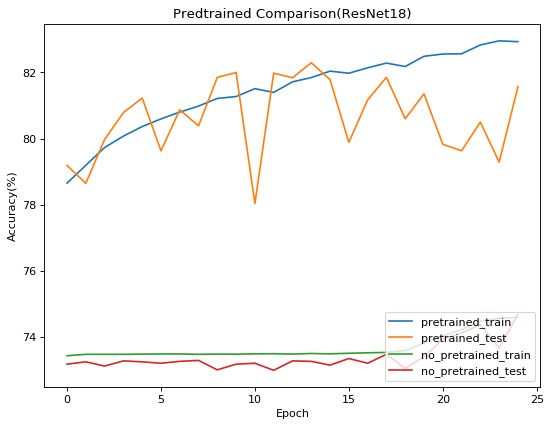

In [16]:
plt.figure(figsize=(8, 6), dpi=80)
plt.title("Predtrained Comparison(ResNet18)")
plt.ylabel("Accuracy(%)")
plt.xlabel("Epoch")
plt.plot(res18_p_train_accu, label="pretrained_train")
plt.plot(res18_p_test_accu, label="pretrained_test")
plt.plot(res18_np_train_accu, label="no_pretrained_train")
plt.plot(res18_np_test_accu, label="no_pretrained_test")
plt.legend(loc='lower right')

In [11]:
#resnet50
res50p_optimizer = optim.SGD(res50_pretrain.parameters(), lr=lr, momentum=0.9, nesterov=True, weight_decay=5e-4)
res50_p_train_accu, res50_p_test_accu = train(res50_p_dir, res50_pretrain, epochs=res50_epochs, optimizer=res50p_optimizer)
res50np_optimizer = optim.SGD(res50_no_pretrain.parameters(), lr=lr, momentum=0.9, nesterov=True, weight_decay=5e-4)
res50_np_train_accu, res50_np_test_accu = train(res50_np_dir, res50_no_pretrain, epochs=res50_epochs, optimizer=res50np_optimizer)

Finish epoch 0, Accuracy 74.45104808000285%, Loss 0.7883723378181458
Test Accuracy 76.99644128113879%
Saving new model, epoch 0
Finish epoch 1, Accuracy 76.66820883305456%, Loss 0.7075781226158142
Test Accuracy 77.09608540925267%
Saving new model, epoch 1
Finish epoch 2, Accuracy 77.67180326702018%, Loss 0.6771471500396729
Test Accuracy 78.80427046263345%
Saving new model, epoch 2
Finish epoch 0, Accuracy 72.57909534147123%, Loss 0.932822048664093
Test Accuracy 73.20996441281139%
Saving new model, epoch 0
Finish epoch 1, Accuracy 73.45813018256878%, Loss 0.8891614675521851
Test Accuracy 73.35231316725978%
Saving new model, epoch 1
Finish epoch 2, Accuracy 73.50795401971601%, Loss 0.8801515102386475
Test Accuracy 73.35231316725978%


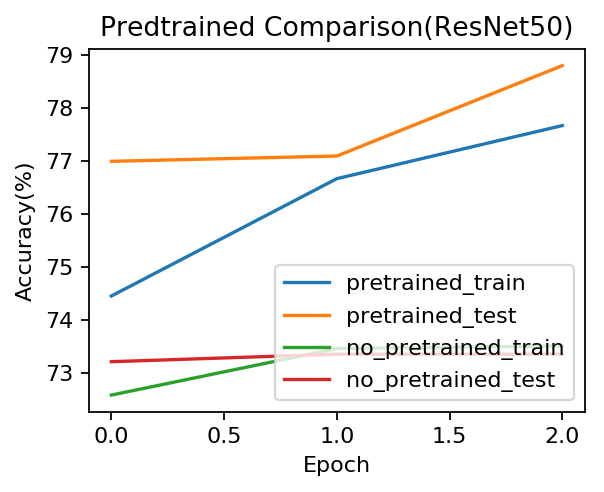

In [16]:
plt.figure(figsize=(4, 3), dpi=160)
plt.title("Predtrained Comparison(ResNet50)")
plt.ylabel("Accuracy(%)")
plt.xlabel("Epoch")
plt.plot(res50_p_train_accu, label="pretrained_train")
plt.plot(res50_p_test_accu, label="pretrained_test")
plt.plot(res50_np_train_accu, label="no_pretrained_train")
plt.plot(res50_np_test_accu, label="no_pretrained_test")
plt.legend(loc='lower right')

# Plot Confusion Matrix

In [11]:
def plot_confusion_matrix(y_true, y_pred,cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    title = 'Normalized confusion matrix'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = ['0', '1', '2', '3', '4']
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print("Normalized confusion matrix")
    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    #plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
    #         rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [12]:
model_path = os.path.join(res18_p_dir,"epoch_13_accu_82.292.pth")
model = resnet18()
model = model.cuda()
model.load_state_dict(torch.load(model_path))
model.eval()
y_true = []
y_pred = []
accurate = 0
for iter, batch in enumerate(res18_test_loader):            
    if use_gpu:
        inputs = Variable(batch[0].cuda())
        labels = Variable(batch[1].cuda())
    else:
        inputs = Variable(batch[0])
        labels = Variable(batch[1])   
    outputs = model(inputs)
    for index, output in enumerate(outputs):
        y_true.append(labels[index].item())
        y_pred.append(torch.argmax(output).item())
        if torch.argmax(output).item() == labels[index].item():
            accurate += 1 
accuracy = 100*accurate/(len(res18_test_loader)*batch_size_18)
print("----Test Accuracy {}%----".format(accuracy))

----Test Accuracy 82.11647727272727%----


Normalized confusion matrix
[[  9.70502620e-01   1.55249369e-03   2.67805162e-02   1.94061712e-04
    9.70308558e-04]
 [  8.38114754e-01   1.84426230e-02   1.43442623e-01   0.00000000e+00
    0.00000000e+00]
 [  3.66913124e-01   2.77264325e-03   5.91497227e-01   2.40295749e-02
    1.47874307e-02]
 [  6.85714286e-02   0.00000000e+00   5.25714286e-01   3.48571429e-01
    5.71428571e-02]
 [  1.49606299e-01   0.00000000e+00   2.12598425e-01   8.66141732e-02
    5.51181102e-01]]


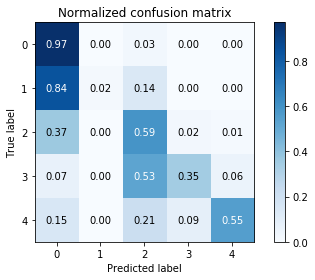

In [13]:
plot_confusion_matrix(y_true, y_pred)